# Cognition and computation project

 Name and surname : Roman Gellert
 Matricola N. : 2109260
 Dataset : omniglot

In [74]:
# library imports
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing

from DBN import DBN

In [45]:
# checking if cuda is available and choosing it to speed up computing
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [84]:
omniglot_tr = tv.datasets.Omniglot(root="../omniglot", download=True, background=True, transform=ToTensor())
omniglot_te = tv.datasets.Omniglot(root="../omniglot", download=True, background=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [85]:
len(omniglot_tr)

19280

In [86]:
len(omniglot_te)

13180

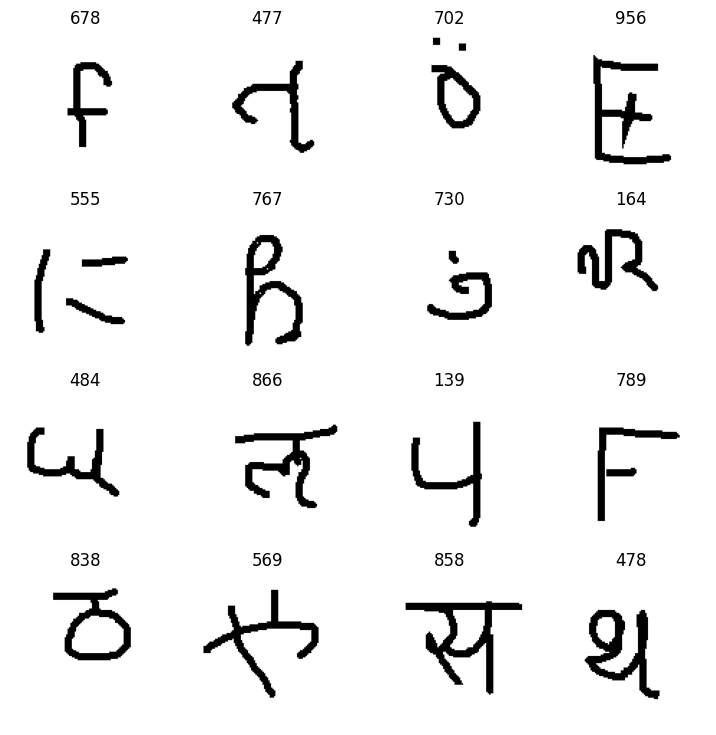

In [73]:
figure = plt.figure(figsize=(9, 9))
for i in range(1, 17):
    dataset_id = torch.randint(len(omniglot_tr), size=(1,)).item()
    img, label = omniglot_tr[dataset_id]
    figure.add_subplot(4, 4, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [116]:
data_loader_tr = torch.utils.data.DataLoader(omniglot_tr,
                                          batch_size=len(omniglot_tr),
                                          shuffle=False)

data_loader_te = torch.utils.data.DataLoader(omniglot_te,
                                             batch_size=len(omniglot_te),
                                             shuffle=False)

In [131]:
train_data, train_labels = next(iter(data_loader_tr))
test_data, test_labels = next(iter(data_loader_te))

In [132]:
train_data = train_data.squeeze()
test_data = test_data.squeeze()

In [133]:
train_data.to(device)
train_labels.to(device)
test_data.to(device)
test_labels.to(device)

tensor([365, 517, 409,  ..., 621,  60, 348], device='cuda:0')

In [135]:
print(train_data.size())
print(test_data.size())

torch.Size([19280, 105, 105])
torch.Size([13180, 105, 105])


In [136]:
dbn_mnist = DBN(visible_units=105 * 105,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())
num_epochs = 50
batch_size = 125

dbn_mnist.train_static(
    train_data,
    train_labels,
    num_epochs,
    batch_size
)

KeyboardInterrupt: 